In [26]:
import math
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import poppy as pp
import organized_functions as pr

%load_ext autoreload # reload 'autoreload'
%autoreload 2 # autonomously reload all import modules
%matplotlib inline # directly show images in the notebook


ModuleNotFoundError: No module named "autoreload # reload 'autoreload'"

# Generate the pupil image

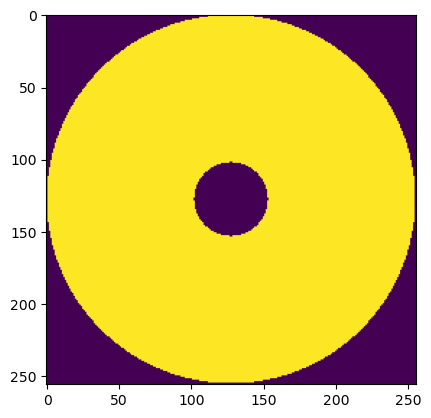

In [27]:
wavelength = 800e-9 # wavelength in meters
od_pupil = 0.3808 # outer pupil diameter in meters
id_pupil = 0.0762 # inner pupil diameter in meters
npix_pupil = 256 # sampling rate on a single side of the pupil

x = cp.linspace(-od_pupil / 2, od_pupil / 2, npix_pupil) # give a 1 x 512 vector in range [-d_pupil/2, d_pupil/2]
x, y = cp.meshgrid(x, x) # use 2 vectors to generate 2 mesh grids
r = cp.sqrt(x ** 2 + y ** 2) # radius

pupil = cp.ones_like(r) # create a matrix whose size and data format are similar to 'r' and value is 1
pupil[r >= od_pupil / 2] = 0 # update the pupil according to the positions obtained through 'r'
pupil[r <= id_pupil / 2] = 0

plt.imshow(pupil.get())
plt.show()


# Read the captured data


(21, 25, 25)
(21, 256, 256)
(21,)


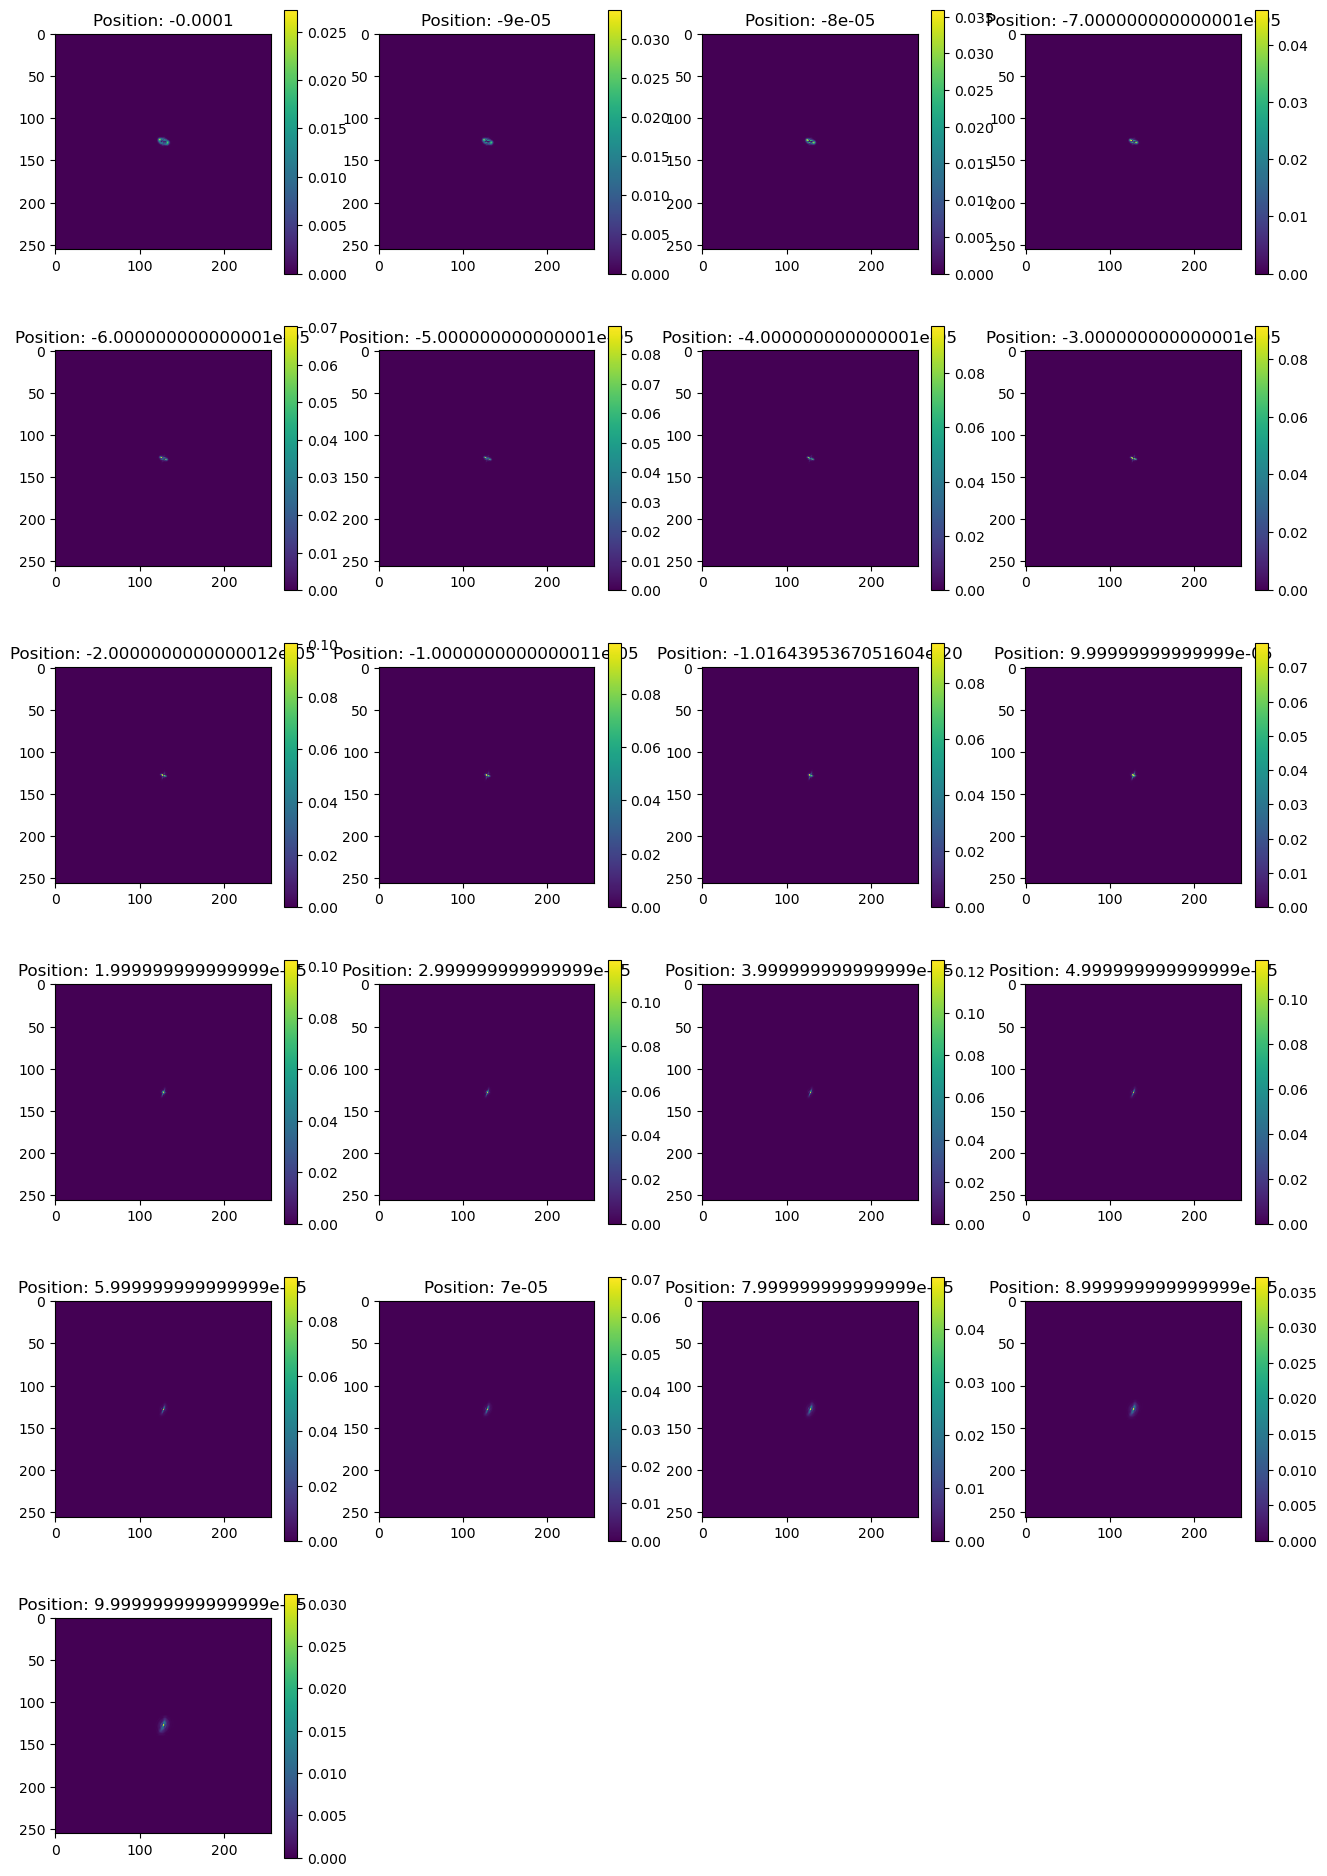

In [22]:
image_raw = np.load('C:/Users/yiyan/OneDrive/Desktop/Wavefront propagations/sensor_measurements.npy')
print(image_raw.shape) # data shape

# Image padding
psf_rows = image_raw.shape[1]
psf_cols = image_raw.shape[2]
upper_padding = round((npix_pupil - psf_rows) / 2)
lower_padding = npix_pupil - psf_rows - upper_padding
left_padding = round((npix_pupil - psf_cols) / 2)
right_padding = npix_pupil - psf_cols - left_padding
image = np.pad(image_raw, pad_width=((0, 0), (upper_padding, lower_padding), (left_padding, right_padding)), mode='constant', constant_values=0)
print(image.shape)

depth = image.shape[0] # image layer
col_num = 4 # column number of images for display
row_num = math.ceil(depth / col_num) # row number of images for display

position = np.load('C:/Users/yiyan/OneDrive/Desktop/Wavefront propagations/distances.npy')
print(position.shape)

image = cp.asarray(image)
position = cp.asarray(position)

image_size = 4
plt.figure(figsize=(image_size * col_num, image_size * row_num))
for i in range(depth):
    position_info = position[i]
    plt.subplot(row_num, col_num, i+1)
    plt.imshow(image[i].get())
    plt.title(f'Position: {position_info}')
    plt.colorbar()

plt.show()


# Give the defocus wavefront


(21,)


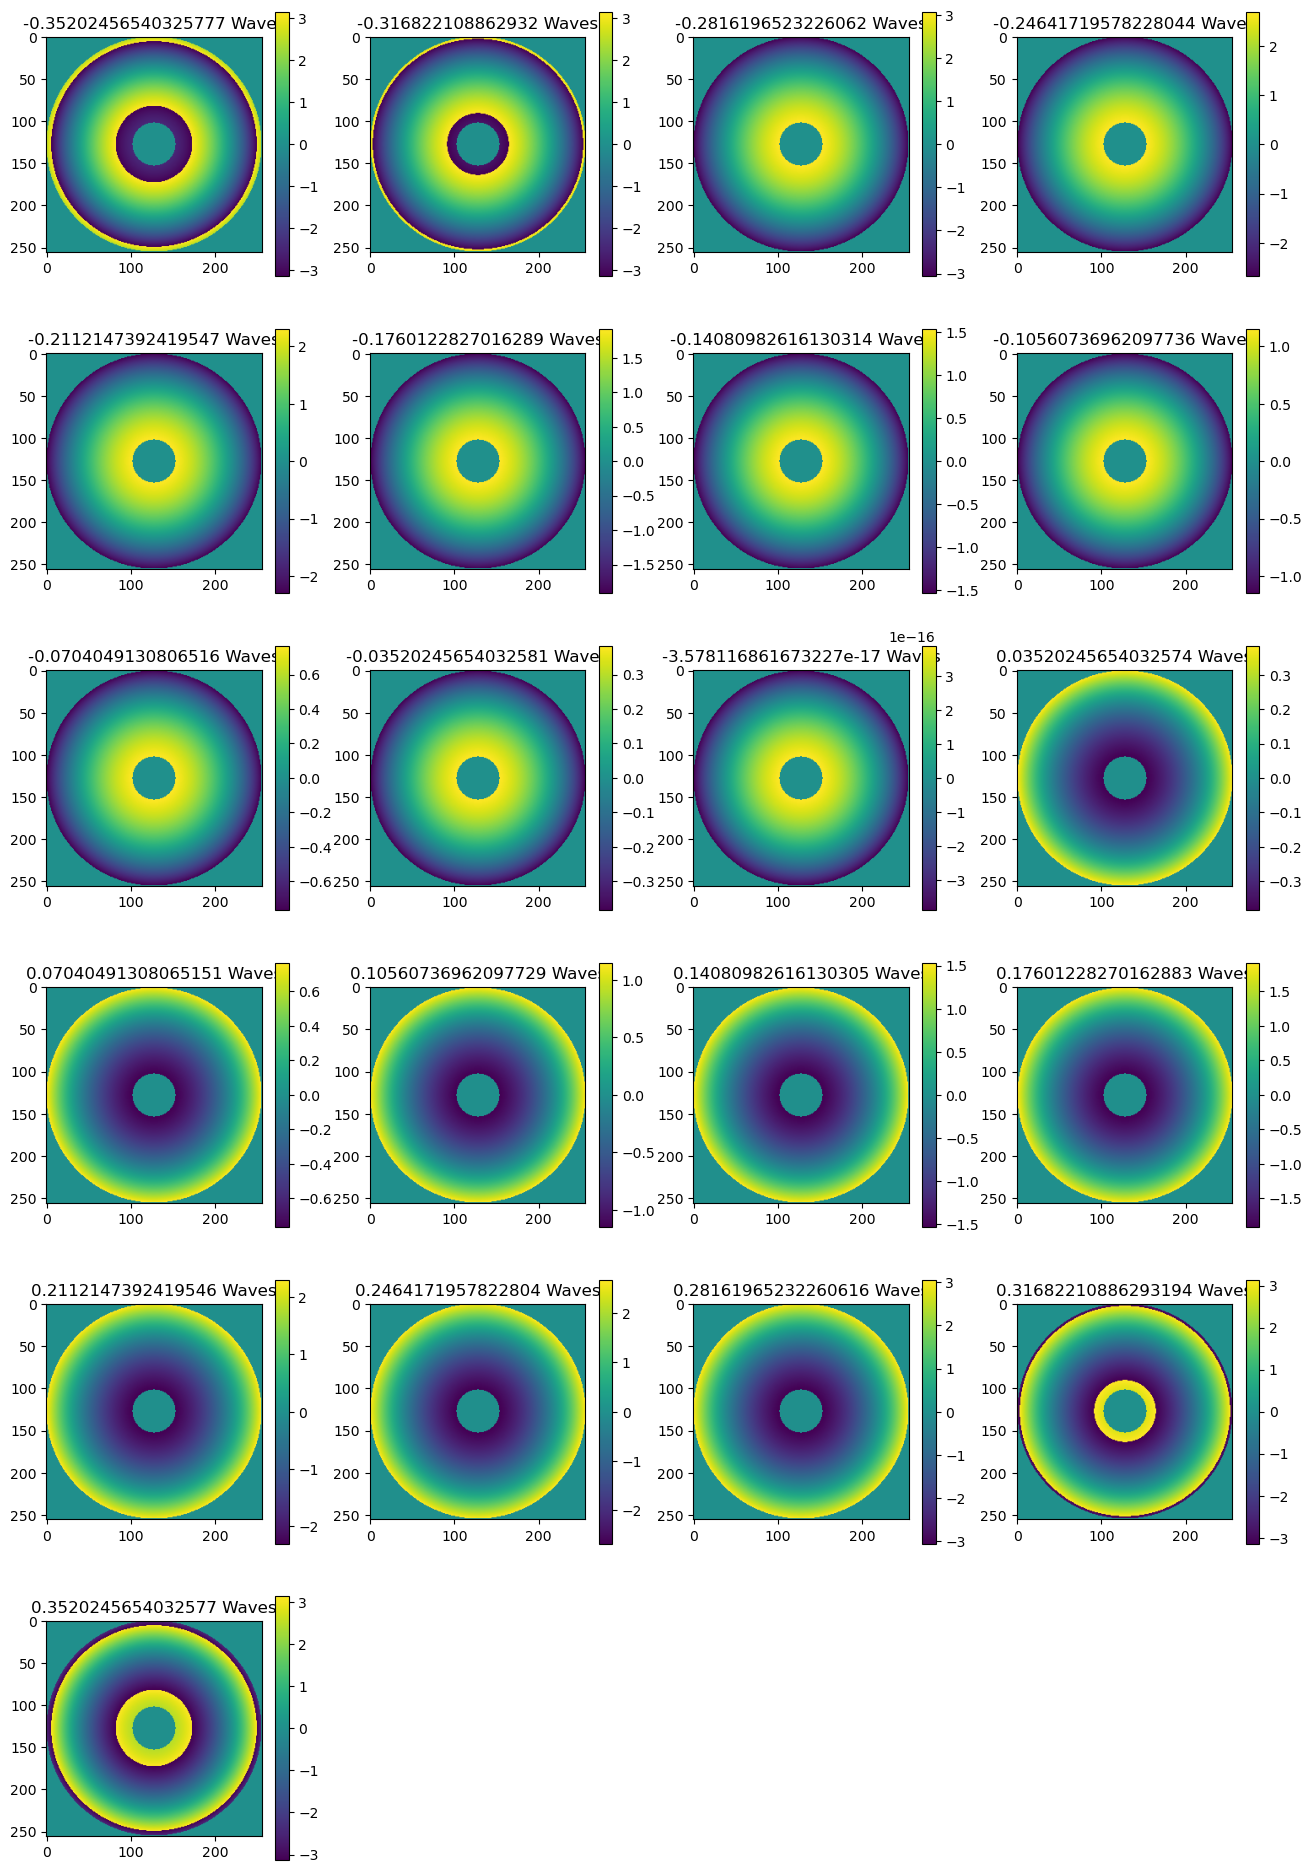

<class 'cupy.ndarray'>


In [23]:
# defocus_values = [-1, -0.5, 0.5, 1] # waves
focal_length = 2.537
defocus_values = position / (8 * wavelength * (focal_length / od_pupil) ** 2) # defocus distance is calculated from L = 8Qλ(f/D)^2
print(defocus_values.shape)
probes = pr.get_defocus_probes(pupil, defocus_values) # get the wavefronts of different defocus magintudes

plt.figure(figsize=(image_size * col_num, image_size * row_num))
for i in range(depth):
    position_info = defocus_values[i]
    plt.subplot(row_num, col_num, i+1)
    plt.imshow(np.angle(probes[i].get()))
    plt.title(f'{position_info} Waves')
    plt.colorbar()
    
plt.show()
print(type(probes))

# Do phase retrieval


In [28]:
focal_intensities = image
zernikes = pp.zernike.arbitrary_basis(pupil, nterms=11, outside=0) # give the bases of the first 11 zernike polynomials inside 'pupil', and set the data outside the mask to be 0
phase_retrieval_dict = pr.run_phase_retrieval(Imeas=focal_intensities, fitmask=pupil, Eprobes=probes, modes=zernikes, tol=1e-8, reg=0, wreg=1e3, fit_amp=False) 
estimated_coeffs = phase_retrieval_dict['fit_params'] # returns in units of radians

plt.figure()
plt.plot(np.arange(11) + 1, estimated_coeffs / 2 / np.pi)
plt.xlabel("Zernike")
plt.ylabel("Estimated Phase (Waves)")
plt.show()


TypeError: Unsupported type <class 'numpy.ndarray'>